In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import msgpack

In [4]:
with open("/home/ubuntu/mantis-module/ctls/lineage", 'rb') as f:
    unpacker = msgpack.Unpacker(f)
    lineage = list(unpacker)

In [5]:
from itertools import chain
flattened_lineage = list(chain.from_iterable(lineage))
lineage_df = pd.DataFrame(flattened_lineage)

In [6]:
lineage_df

,b'_1_lg_sent',b'_2_enqueue_time',b'_3_dequeue_time',b'_4_done_time',b'query_id'
0,1.577394e+09,1.577394e+09,1.577394e+09,1.577394e+09,106
1,1.577394e+09,1.577394e+09,1.577394e+09,1.577394e+09,104
2,1.577394e+09,1.577394e+09,1.577394e+09,1.577394e+09,105
3,1.577394e+09,1.577394e+09,1.577394e+09,1.577394e+09,103
4,1.577394e+09,1.577394e+09,1.577394e+09,1.577394e+09,102
...,...,...,...,...,...
76488,1.577394e+09,1.577394e+09,1.577394e+09,1.577394e+09,76327
76489,1.577394e+09,1.577394e+09,1.577394e+09,1.577394e+09,76325
76490,1.577394e+09,1.577394e+09,1.577394e+09,1.577394e+09,76324
76491,1.577394e+09,1.577394e+09,1.577394e+09,1.577394e+09,76323


In [10]:
observed_deltas = np.diff(sorted(lineage_df[b"_1_lg_sent"]))*1000
e2e_lats = np.array(lineage_df[b"_4_done_time"] - lineage_df[b"_1_lg_sent"])*1000
e2e_lats_ts = np.array(sorted(lineage_df[b"_1_lg_sent"]))
e2e_lats_ts-=e2e_lats_ts[0]

In [20]:
processing_times = np.array(lineage_df[b"_4_done_time"] - lineage_df[b"_3_dequeue_time"]) * 1000. 

In [22]:
queue_times = np.array(lineage_df[b"_3_dequeue_time"] - lineage_df[b"_2_enqueue_time"]) * 1000. 

In [12]:
with open("/home/ubuntu/mantis-module/ctls/metrics", 'rb') as f:
    unpacker = msgpack.Unpacker(f)
    metrics = list(unpacker)

In [13]:
metrics_ts = np.array([m[b"current_time_ns"] for m in metrics])
metrics_ts-=metrics_ts[0]
metrics_ts = metrics_ts/1e9

In [14]:
active_rf = [m[b'num_active_replica'] for m in metrics]
active_queue_size = [np.sum(m[b"queue_sizes"]) for m in metrics]

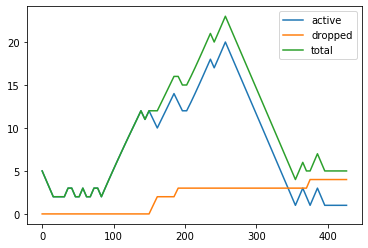

In [15]:
plt.plot(metrics_ts, [m[b'num_active_replica'] for m in metrics], label="active")
plt.plot(metrics_ts, [m[b'num_dropped_replica'] for m in metrics], label="dropped")
plt.plot(metrics_ts, [m[b'num_total_replica'] for m in metrics], label="total")
plt.legend()

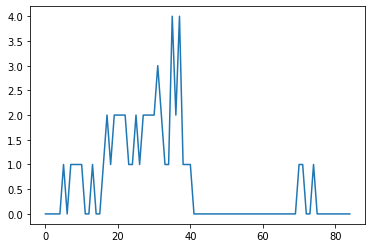

In [72]:
plt.plot([np.max(m[b"queue_sizes"]) - np.min(m[b"queue_sizes"]) for m in metrics])

In [16]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_deltas(deltas, **kwargs):
    kernel = 1000
    plt.plot(np.cumsum(deltas)[kernel//2-1:-(kernel//2)]/1000., 1000./moving_average(deltas, kernel), **kwargs)

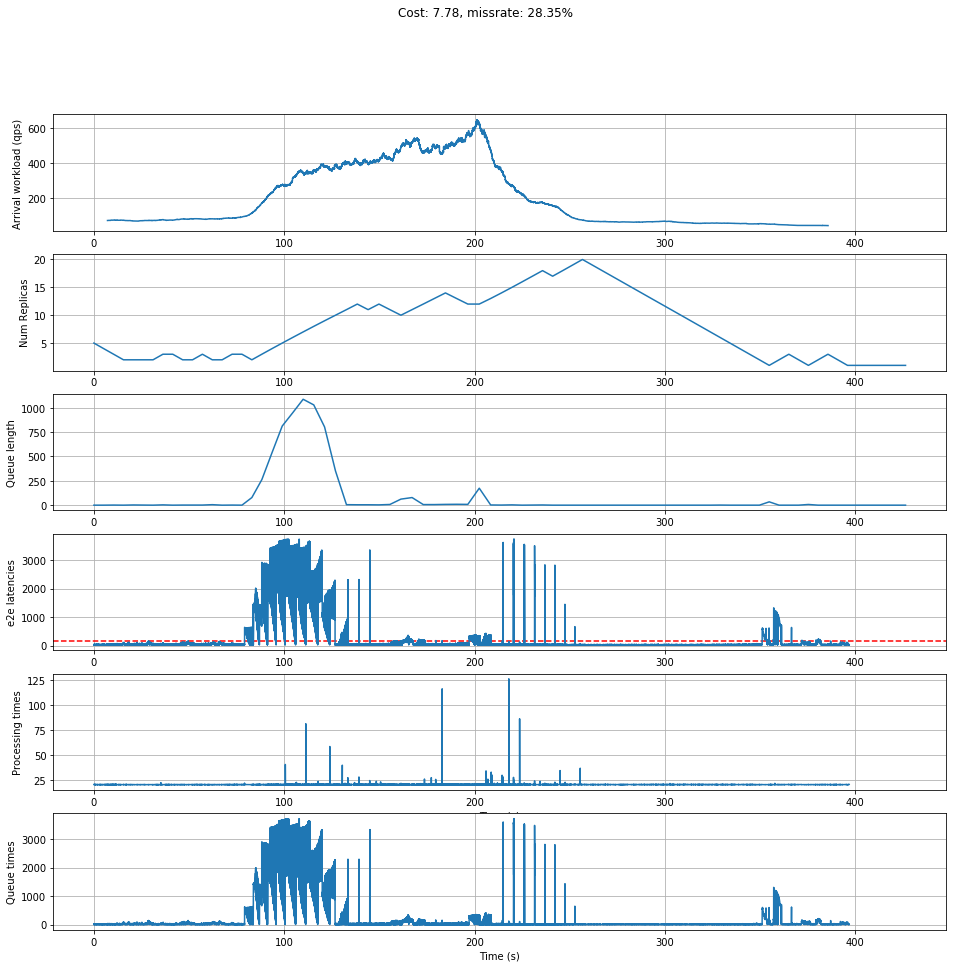

In [23]:
fig=plt.figure(figsize=(16,15))
slo = 150
missrate = np.sum(e2e_lats > slo) / len(observed_deltas)
cost = np.mean(active_rf)
plt.suptitle("Cost: {}, missrate: {}%".format(round(cost, 2), round(missrate*100, 2)))
ax1 = plt.subplot(6,1,1)
plt.ylabel("Arrival workload (qps)")
plt.grid()
plot_deltas(observed_deltas)
ax2 = plt.subplot(6,1,2, sharex = ax1)
plt.ylabel("Num Replicas")
plt.grid()
plt.plot(metrics_ts, active_rf)
ax2 = plt.subplot(6,1,3, sharex = ax1)
plt.ylabel("Queue length")
plt.grid()
plt.plot(metrics_ts, active_queue_size)
ax2 = plt.subplot(6,1,4, sharex = ax1)
plt.ylabel("e2e latencies")
plt.grid()
plt.axhline(y=slo, color="red", linestyle="--")
plt.plot(e2e_lats_ts, e2e_lats)
ax2 = plt.subplot(6,1,5, sharex = ax1)
plt.plot(e2e_lats_ts, processing_times)
plt.ylabel("Processing times")
plt.xlabel("Time (s)")
plt.grid()
ax2 = plt.subplot(6,1,6, sharex = ax1)
plt.plot(e2e_lats_ts, queue_times)
plt.ylabel("Queue times")
plt.xlabel("Time (s)")
plt.grid()

In [3]:
rf = [5, 4, 5, 6, 7, 8, 9, 9, 8, 9, 10, 10, 9, 9, 10, 11, 12, 13, 13, 13, 13, 14, 15, 16, 17, 18, 19, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 4, 5, 4, 3, 4, 5, 6, 5, 4, 3, 4, 5, 4, 3, 4]
ql = [5, 23, 73, 98, 6, 9, 8, 5, 21, 16, 10, 7, 14, 21, 75, 97, 5, 6, 9, 30, 119, 345, 2, 7, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 3, 58, 3, 4, 2, 42, 2, 2, 2, 2, 2, 6, 3, 2, 2, 4, 2]

In [8]:
lats_data = [{100:0.061859846115112305, 25:0.02080845832824707, 50:0.02097606658935547, 95:0.0395921230316162, 99:0.04131002426147461},
{100:0.1444699764251709, 25:0.02203291654586792, 50:0.03698885440826416, 95:0.10041893720626817, 99:0.12029122114181517},
{100:0.4825167655944824, 25:0.22369980812072754, 50:0.2538031339645386, 95:0.42605990171432495, 99:0.46303232431411745},
{100:0.7362782955169678, 25:0.3507190942764282, 50:0.3955972194671631, 95:0.6671488881111145, 99:0.7112754106521607},
{100:0.41636204719543457, 25:0.05726802349090576, 50:0.14117884635925293, 95:0.3536407828330993, 99:0.3834114861488342},
{100:0.20915794372558594, 25:0.03818941116333008, 50:0.056996941566467285, 95:0.16934064626693718, 99:0.18780039787292477},
{100:0.18774843215942383, 25:0.025257587432861328, 50:0.036728620529174805, 95:0.07577888965606686, 99:0.10010334968566896},
{100:0.09000706672668457, 25:0.026381373405456543, 50:0.036719322204589844, 95:0.060411357879638666, 99:0.07407448768615722},
{100:0.19733071327209473, 25:0.04665517807006836, 50:0.06740617752075195, 95:0.13631162643432615, 99:0.16034323692321784},
{100:0.20145249366760254, 25:0.04549306631088257, 50:0.06609058380126953, 95:0.15632236003875732, 99:0.17230095863342287},
{100:0.18771123886108398, 25:0.026391923427581787, 50:0.036884307861328125, 95:0.06719753742218015, 99:0.09776378393173243},
{100:0.08298444747924805, 25:0.022449910640716553, 50:0.03407943248748779, 95:0.058780443668365476, 99:0.07140077114105221},
{100:0.10548138618469238, 25:0.03539884090423584, 50:0.04703712463378906, 95:0.08099824190139768, 99:0.09571021080017084},
{100:0.20400333404541016, 25:0.08156967163085938, 50:0.1042640209197998, 95:0.17133460044860838, 99:0.19193283081054668},
{100:0.22896933555603027, 25:0.07648050785064697, 50:0.10294198989868164, 95:0.1836850881576538, 99:0.2029092121124268},
{100:0.48347926139831543, 25:0.20294880867004395, 50:0.23837924003601074, 95:0.3969480037689205, 99:0.45932698249816906},
{100:0.2633092403411865, 25:0.03752255439758301, 50:0.17014503479003906, 95:0.23831963539123535, 99:0.2500190734863281},
{100:0.1945631504058838, 25:0.021086812019348145, 50:0.033168792724609375, 95:0.05549478530883789, 99:0.07187291145324602},
{100:0.08031415939331055, 25:0.023303508758544922, 50:0.03452026844024658, 95:0.057731032371520996, 99:0.06540791988372811},
{100:0.1161050796508789, 25:0.03455239534378052, 50:0.04622852802276611, 95:0.080345356464386, 99:0.09515810728073125},
{100:0.2530217170715332, 25:0.0863608717918396, 50:0.10543930530548096, 95:0.2043296933174133, 99:0.22894612550735471},
{100:0.602165937423706, 25:0.3005554676055908, 50:0.38408827781677246, 95:0.558993399143219, 99:0.5837805938720704},
{100:0.6626484394073486, 25:0.3464539051055908, 50:0.5427265167236328, 95:0.6251218676567079, 99:0.6408660101890564},
{100:0.6089346408843994, 25:0.020732879638671875, 50:0.02642989158630371, 95:0.07853975296020507, 99:0.2466068363189699},
{100:0.4065871238708496, 25:0.02071434259414673, 50:0.02097141742706299, 95:0.04101626873016358, 99:0.373248097896576},
{100:0.3895905017852783, 25:0.020702838897705078, 50:0.020815372467041016, 95:0.04032917022705078, 99:0.32749995231628415},
{100:0.32946109771728516, 25:0.020720958709716797, 50:0.020821452140808105, 95:0.0394460916519165, 99:0.12326525688171384},
{100:0.05171012878417969, 25:0.020718812942504883, 50:0.02081584930419922, 95:0.03719644546508788, 99:0.040311517715454104},
{100:0.04500555992126465, 25:0.020723700523376465, 50:0.02081918716430664, 95:0.03783016204833984, 99:0.04049454689025879},
{100:0.04125070571899414, 25:0.02072930335998535, 50:0.020810604095458984, 95:0.03783369064331055, 99:0.0403122615814209},
{100:0.0406649112701416, 25:0.020740509033203125, 50:0.020834684371948242, 95:0.0341966152191162, 99:0.03839085578918456},
{100:0.041245222091674805, 25:0.020758509635925293, 50:0.02085113525390625, 95:0.03628630638122558, 99:0.04066254138946533},
{100:0.04140615463256836, 25:0.020774483680725098, 50:0.020888924598693848, 95:0.03359153270721435, 99:0.0392340803146362},
{100:0.04062843322753906, 25:0.020769119262695312, 50:0.02088141441345215, 95:0.033930301666259766, 99:0.03940682411193848},
{100:0.041371822357177734, 25:0.02076512575149536, 50:0.020870566368103027, 95:0.03581947088241577, 99:0.040164718627929696},
{100:0.040975332260131836, 25:0.020792603492736816, 50:0.02090001106262207, 95:0.035915040969848634, 99:0.04016199111938476},
{100:0.0412600040435791, 25:0.02081012725830078, 50:0.02091073989868164, 95:0.036442065238952624, 99:0.04061713695526123},
{100:0.04094052314758301, 25:0.020784199237823486, 50:0.020894885063171387, 95:0.03616998195648194, 99:0.038968799114227286},
{100:0.0410761833190918, 25:0.02080535888671875, 50:0.020910263061523438, 95:0.0375521183013916, 99:0.04055256843566896},
{100:0.05327773094177246, 25:0.020806729793548584, 50:0.020933866500854492, 95:0.038026833534240724, 99:0.04109385013580322},
{100:0.05605888366699219, 25:0.02080988883972168, 50:0.02092289924621582, 95:0.039742469787597656, 99:0.044229173660278405},
{100:0.047683000564575195, 25:0.02084207534790039, 50:0.021002769470214844, 95:0.03873262405395508, 99:0.040857582092285155},
{100:0.055346012115478516, 25:0.020856499671936035, 50:0.021087646484375, 95:0.039172148704528814, 99:0.04242542982101437},
{100:0.06386852264404297, 25:0.02102559804916382, 50:0.03140866756439209, 95:0.050958323478698726, 99:0.06071806430816645},
{100:1.218207597732544, 25:0.3636317849159241, 50:0.7763633728027344, 95:1.120807087421417, 99:1.1835030484199525},
{100:1.643988847732544, 25:0.22215032577514648, 50:0.42141056060791016, 95:1.5518877983093264, 99:1.6241313934326171},
{100:0.06068158149719238, 25:0.020891666412353516, 50:0.024568796157836914, 95:0.0444620370864868, 99:0.05736178159713745},
{100:0.08218598365783691, 25:0.020985662937164307, 50:0.03189229965209961, 95:0.05627490282058716, 99:0.07058142900466918},
{100:1.195293664932251, 25:0.08391284942626953, 50:0.23899459838867188, 95:0.664269495010376, 99:0.6866103744506835},
{100:1.2704951763153076, 25:0.0405193567276001, 50:0.17258262634277344, 95:1.1860132813453674, 99:1.2484210038185117},
{100:0.7095119953155518, 25:0.020897626876831055, 50:0.023284196853637695, 95:0.04130816459655762, 99:0.27126209259034006},
{100:0.6898515224456787, 25:0.020862579345703125, 50:0.021042823791503906, 95:0.04030709266662598, 99:0.05320018768310549},
{100:0.05050253868103027, 25:0.020863056182861328, 50:0.02101898193359375, 95:0.03980698585510254, 99:0.040933604240417476},
{100:0.05966353416442871, 25:0.020921707153320312, 50:0.025733470916748047, 95:0.04069924354553223, 99:0.049865126609802246},
{100:0.22540831565856934, 25:0.03501176834106445, 50:0.05747628211975098, 95:0.13558065891265866, 99:0.2101280641555786},
{100:0.21490979194641113, 25:0.02409839630126953, 50:0.04024648666381836, 95:0.18527793884277344, 99:0.2054309844970703},
{100:0.062139034271240234, 25:0.020888090133666992, 50:0.021112918853759766, 95:0.040613412857055664, 99:0.06107366085052489},
{100:0.05461931228637695, 25:0.020907044410705566, 50:0.0238722562789917, 95:0.03996962308883667, 99:0.04351203680038454},
{100:0.14532804489135742, 25:0.027921557426452637, 50:0.05126368999481201, 95:0.11252280473709106, 99:0.13033664703369144},
{100:0.0821983814239502, 25:0.021037578582763672, 50:0.030626296997070312, 95:0.07008570432662962, 99:0.07913997650146484},]

In [20]:
df = pd.DataFrame(lats_data)

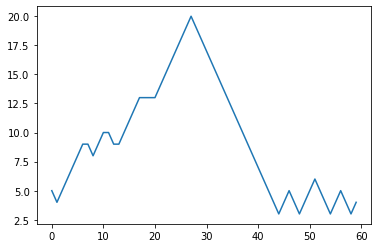

In [18]:
plt.plot(rf)

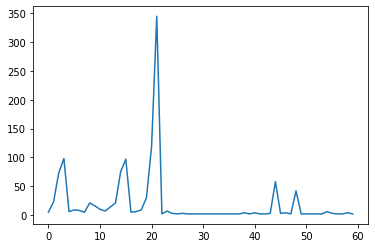

In [19]:
plt.plot(ql)

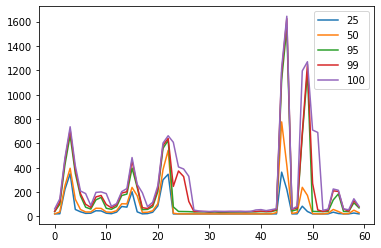

In [21]:
for c in sorted(df.columns):
    plt.plot(df[c]*1000, label=c)
    plt.legend()

In [2]:
import msgpack